<a href="https://colab.research.google.com/github/hemanth346/eva4/blob/master/S5/M4_S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model 4

### Target :

1. Add LR manager

### Results :
1.  Parameters: 9,430
1. Best Train Accuracy: 99.69
1. Best Test Accuracy: 99.44 

### Analysis
1. Achieved target accuracy for mulitple epochs
1. Many epochs with accuracy above 99.38
1. Over-fitting is having effect on the model now. Add regularization next
1. Plots gone crazy.! On googling, found that these plots are similar to cosine annealing learning rate (not sure what that is, yet).



In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from IPython.display import Image # to display PIL images


In [0]:
# # dataset - Creating train and test
# train = datasets.MNIST('./data', train=True, download=True)
# test = datasets.MNIST('./data', train=False, download=True)
# # As PIL.Image
# x, y = train[7777]
# print(y)
# display(x)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [4]:
# dataset - Creating train and test
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


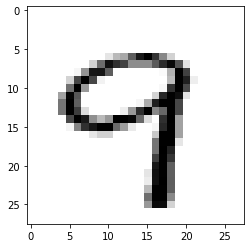

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


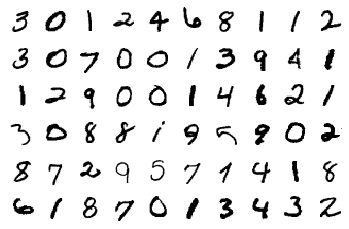

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [0]:
def conv_block(in_channels, out_channels, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.BatchNorm2d(out_channels), # < added this
        nn.ReLU()
        )
    


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = conv_block(in_channels=1, out_channels=10, kernel_size=3, padding=1, bias=False) #28, rf 3      
        self.conv2 = conv_block(in_channels=10, out_channels=20, kernel_size=3, bias=False) #26, rf 5       
        self.pool = nn.MaxPool2d(2, 2)  #13, rf 6                     
        
        self.conv3 = conv_block(in_channels=20, out_channels=10, kernel_size=3, bias=False)  #11, rf 10     
        self.conv4 = conv_block(in_channels=10, out_channels=20, kernel_size=3, bias=False)  # 9, rf 14    
        self.conv5 = conv_block(in_channels=20, out_channels=10, kernel_size=3, bias=False)  # 7, rf 18   

        # No relu, BN before GAP/Last layer
        self.conv6 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, bias=False) #5, rf 22              

        self.gap = nn.AdaptiveAvgPool2d((1,1)) #1, rf 30                                                                   
        self.pconv1 = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1, bias=False) #1, rf 30     

    def forward(self, x):
        x = self.pool(self.conv2(self.conv1(x)))

        x = self.conv4(self.conv3(x))
        x = self.conv6(self.conv5(x))
        
        x = self.gap(x)
        x = self.pconv1(x)
        x = x.view(-1, 10)

        return F.log_softmax(x)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 20, 26, 26]           1,800
       BatchNorm2d-5           [-1, 20, 26, 26]              40
              ReLU-6           [-1, 20, 26, 26]               0
         MaxPool2d-7           [-1, 20, 13, 13]               0
            Conv2d-8           [-1, 10, 11, 11]           1,800
       BatchNorm2d-9           [-1, 10, 11, 11]              20
             ReLU-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 20, 9, 9]           1,800
      BatchNorm2d-12             [-1, 20, 9, 9]              40
             ReLU-13             [-1, 20, 9, 9]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [18]:
model =  Net().to(device)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    if epoch < 8:
        print('Learning rate :',0.03)
        optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
    elif epoch < 11:
        print('Learning rate :',0.003)
        optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    else:
        print('Learning rate :',0.0003)
        optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
Learning rate : 0.03


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.029104003682732582 Batch_id=468 Accuracy=90.99: 100%|██████████| 469/469 [00:10<00:00, 43.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9816/10000 (98.16%)

EPOCH: 1
Learning rate : 0.03


Loss=0.02781517803668976 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:10<00:00, 42.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0868, Accuracy: 9725/10000 (97.25%)

EPOCH: 2
Learning rate : 0.03


Loss=0.021465161815285683 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:10<00:00, 45.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9871/10000 (98.71%)

EPOCH: 3
Learning rate : 0.03


Loss=0.005362376570701599 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:10<00:00, 44.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9906/10000 (99.06%)

EPOCH: 4
Learning rate : 0.03


Loss=0.033781301230192184 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:10<00:00, 42.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9907/10000 (99.07%)

EPOCH: 5
Learning rate : 0.03


Loss=0.05229444429278374 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:10<00:00, 44.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9894/10000 (98.94%)

EPOCH: 6
Learning rate : 0.03


Loss=0.06706664711236954 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:10<00:00, 43.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9908/10000 (99.08%)

EPOCH: 7
Learning rate : 0.03


Loss=0.016894495114684105 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:10<00:00, 44.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH: 8
Learning rate : 0.003


Loss=0.00204853224568069 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:10<00:00, 44.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH: 9
Learning rate : 0.003


Loss=0.007074778433889151 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:10<00:00, 43.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

EPOCH: 10
Learning rate : 0.003


Loss=0.006303191184997559 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:10<00:00, 48.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9939/10000 (99.39%)

EPOCH: 11
Learning rate : 0.0003


Loss=0.006449421402066946 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:10<00:00, 43.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9939/10000 (99.39%)

EPOCH: 12
Learning rate : 0.0003


Loss=0.00918610394001007 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:10<00:00, 45.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9943/10000 (99.43%)

EPOCH: 13
Learning rate : 0.0003


Loss=0.017853915691375732 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:10<00:00, 45.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 14
Learning rate : 0.0003


Loss=0.003344312310218811 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:10<00:00, 44.78it/s]



Test set: Average loss: 0.0180, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

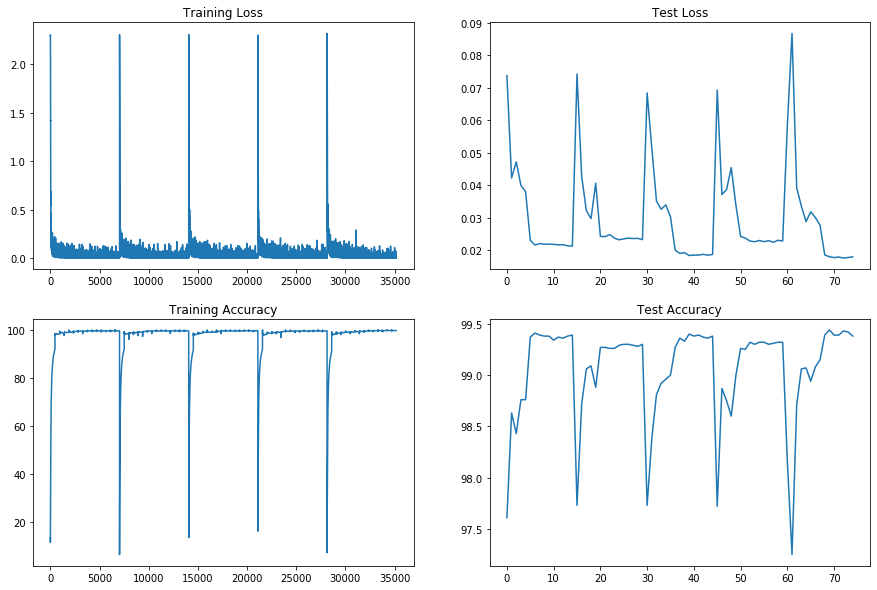

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")